In [ ]:
# Importing Necessary Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython.display import Image, display
import plotly.graph_objects as go
import numpy as np
import os

In [ ]:
# Set device

# If GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Metal Performance Shaders Apple's M1/M2/M3 Chips
# device = "mps" if torch.backends.mps.is_available() else "cpu"

print("Device in use:", device)

# Free up memory
torch.cuda.empty_cache()

Device in use: cuda


In [ ]:
# Hyperparameters
batch_size = 64
lr = 0.0002
latent_size = 100
epochs = 100
lambda_gp = 10

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 170498071/170498071 [00:15<00:00, 10974058.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Define gradient penalty function
def compute_gradient_penalty(real_images, fake_images, discriminator):
    alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(d_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
# Generate images using the generator
def generate_images(generator, num_images):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_size, 1, 1, device=device)
        fake_images = generator(noise)
    return fake_images

In [ ]:
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Learning rate scheduler
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/100] [D loss: -863.4443435567667] [G loss: 400.507770384669]
[Epoch 2/100] [D loss: -2831.0687291177032] [G loss: 1615.6511335055845]
[Epoch 3/100] [D loss: 500.6121579923898] [G loss: 1637.6606145600224]
[Epoch 4/100] [D loss: 25.274929419807766] [G loss: 1650.11053591677]
[Epoch 5/100] [D loss: 9.62879676038347] [G loss: 1614.3815432497302]
[Epoch 6/100] [D loss: -1.0719618343026436] [G loss: 1608.2608533308023]
[Epoch 7/100] [D loss: -1.187487585617758] [G loss: 1603.096534514366]
[Epoch 8/100] [D loss: -1.718413291227482] [G loss: 1600.3199949923073]
[Epoch 9/100] [D loss: -2.3298934911523026] [G loss: 1597.08682742692]
[Epoch 10/100] [D loss: -2.677897782734288] [G loss: 1592.5804310674253]
Model weights checkpoint at epoch10 saved in weights/ directory.
Generated (fake) images at epoch10 saved in gan_images/ directory.


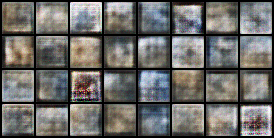

[Epoch 11/100] [D loss: -3.101881855436603] [G loss: 1585.1131285840593]
[Epoch 12/100] [D loss: -3.464998527713444] [G loss: 1578.3556610653773]
[Epoch 13/100] [D loss: -3.805689492493944] [G loss: 1573.8604403834818]
[Epoch 14/100] [D loss: -4.012349526748023] [G loss: 1568.4821135772158]
[Epoch 15/100] [D loss: -4.048985687820503] [G loss: 1559.7858140560063]
[Epoch 16/100] [D loss: -4.0412932501729495] [G loss: 1546.3859835183225]
[Epoch 17/100] [D loss: -4.033072143564444] [G loss: 1530.053811778193]
[Epoch 18/100] [D loss: -3.9910611828879627] [G loss: 1510.1251742077604]
[Epoch 19/100] [D loss: -3.978915592898493] [G loss: 1490.2147151234815]
[Epoch 20/100] [D loss: -3.900422666383826] [G loss: 1469.0454391908768]
Model weights checkpoint at epoch20 saved in weights/ directory.
Generated (fake) images at epoch20 saved in gan_images/ directory.


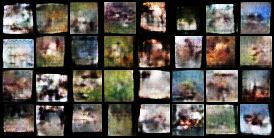

[Epoch 21/100] [D loss: -3.869707169740096] [G loss: 1447.4530027735873]
[Epoch 22/100] [D loss: -3.81903554076124] [G loss: 1425.3108748414022]
[Epoch 23/100] [D loss: -3.70622423847618] [G loss: 1403.2726349891605]
[Epoch 24/100] [D loss: -3.6365448286008957] [G loss: 1379.4052845206102]
[Epoch 25/100] [D loss: -3.6276790184133194] [G loss: 1354.3600363963096]
[Epoch 26/100] [D loss: -3.596429831384088] [G loss: 1331.810806157339]
[Epoch 27/100] [D loss: -3.6295058655616876] [G loss: 1310.2667312817196]
[Epoch 28/100] [D loss: -3.5852009069431774] [G loss: 1292.3477367976743]
[Epoch 29/100] [D loss: -3.6430582787527146] [G loss: 1274.9694430846387]
[Epoch 30/100] [D loss: -3.600541181728968] [G loss: 1259.1903822330562]
Model weights checkpoint at epoch30 saved in weights/ directory.
Generated (fake) images at epoch30 saved in gan_images/ directory.


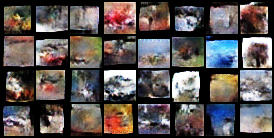

[Epoch 31/100] [D loss: -3.9782366408106618] [G loss: 1251.077144222796]
[Epoch 32/100] [D loss: -4.090565358586324] [G loss: 1250.648454827116]
[Epoch 33/100] [D loss: -4.122676570244762] [G loss: 1250.1555865743885]
[Epoch 34/100] [D loss: -4.144830069273634] [G loss: 1249.483102315527]
[Epoch 35/100] [D loss: -4.156143025364107] [G loss: 1248.9218860831102]
[Epoch 36/100] [D loss: -4.161744905097406] [G loss: 1248.4346165181425]
[Epoch 37/100] [D loss: -4.195334272311472] [G loss: 1247.9655245027275]
[Epoch 38/100] [D loss: -4.248490718014709] [G loss: 1247.5221932257532]
[Epoch 39/100] [D loss: -4.225379008466326] [G loss: 1246.9853771629237]
[Epoch 40/100] [D loss: -4.261286295588364] [G loss: 1246.4703865539082]
Model weights checkpoint at epoch40 saved in weights/ directory.
Generated (fake) images at epoch40 saved in gan_images/ directory.


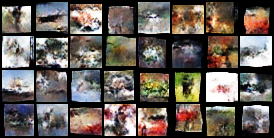

[Epoch 41/100] [D loss: -4.268492272442869] [G loss: 1245.9150670044257]
[Epoch 42/100] [D loss: -4.296608826998249] [G loss: 1245.333082584469]
[Epoch 43/100] [D loss: -4.256528286982681] [G loss: 1244.7488699910587]
[Epoch 44/100] [D loss: -4.282654762877833] [G loss: 1244.1289607289502]
[Epoch 45/100] [D loss: -4.265696445999243] [G loss: 1243.3181289711877]
[Epoch 46/100] [D loss: -4.202021796837487] [G loss: 1242.4688903340293]
[Epoch 47/100] [D loss: -4.176340491570476] [G loss: 1241.7830287611393]
[Epoch 48/100] [D loss: -4.214773236028374] [G loss: 1241.066769807235]
[Epoch 49/100] [D loss: -4.197317900560091] [G loss: 1240.0746004148518]
[Epoch 50/100] [D loss: -4.203526532558529] [G loss: 1239.1991397633271]
Model weights checkpoint at epoch50 saved in weights/ directory.
Generated (fake) images at epoch50 saved in gan_images/ directory.


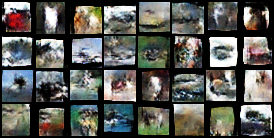

[Epoch 51/100] [D loss: -4.234696221168694] [G loss: 1238.2810431673095]
[Epoch 52/100] [D loss: -3.9507413425713853] [G loss: 1237.8894284923972]
[Epoch 53/100] [D loss: -4.100050840993672] [G loss: 1237.1721356872401]
[Epoch 54/100] [D loss: -3.955219874449093] [G loss: 1236.0783500964073]
[Epoch 55/100] [D loss: -4.1536592481386325] [G loss: 1235.3223625631892]
[Epoch 56/100] [D loss: -4.279562206829295] [G loss: 1234.366738087686]
[Epoch 57/100] [D loss: -4.076107907325715] [G loss: 1233.6813471567295]
[Epoch 58/100] [D loss: -4.087054655832403] [G loss: 1233.081550617657]
[Epoch 59/100] [D loss: -4.191063799211741] [G loss: 1232.0317131491267]
[Epoch 60/100] [D loss: -4.265404417996517] [G loss: 1231.1473822630276]
Model weights checkpoint at epoch60 saved in weights/ directory.
Generated (fake) images at epoch60 saved in gan_images/ directory.


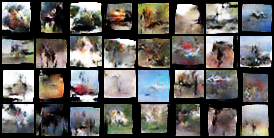

[Epoch 61/100] [D loss: -4.295507420664248] [G loss: 1230.764121131214]
[Epoch 62/100] [D loss: -4.414262072509512] [G loss: 1230.5834325609915]
[Epoch 63/100] [D loss: -4.405797712028484] [G loss: 1230.5841679487692]
[Epoch 64/100] [D loss: -4.431479445656242] [G loss: 1230.3580158360473]
[Epoch 65/100] [D loss: -4.458760679225483] [G loss: 1230.2159155335878]
[Epoch 66/100] [D loss: -4.438983256554665] [G loss: 1230.1713640842293]
[Epoch 67/100] [D loss: -4.4350381900587355] [G loss: 1230.0990981470288]
[Epoch 68/100] [D loss: -4.4304945243289096] [G loss: 1230.0109935087316]
[Epoch 69/100] [D loss: -4.402941192812322] [G loss: 1229.9378857234556]
[Epoch 70/100] [D loss: -4.492005788456753] [G loss: 1229.8580404998702]
Model weights checkpoint at epoch70 saved in weights/ directory.
Generated (fake) images at epoch70 saved in gan_images/ directory.


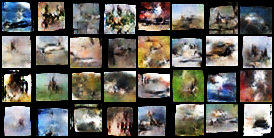

[Epoch 71/100] [D loss: -4.474504382256657] [G loss: 1229.8145271164683]
[Epoch 72/100] [D loss: -4.430126466866954] [G loss: 1229.722597712446]
[Epoch 73/100] [D loss: -4.420736045178855] [G loss: 1229.7410165928209]
[Epoch 74/100] [D loss: -4.464319375774744] [G loss: 1229.656940118736]
[Epoch 75/100] [D loss: -4.4488517291405625] [G loss: 1229.5756050753776]
[Epoch 76/100] [D loss: -4.488238331606931] [G loss: 1229.466154522908]
[Epoch 77/100] [D loss: -4.389645345070782] [G loss: 1229.4119860558862]
[Epoch 78/100] [D loss: -4.536912275702142] [G loss: 1229.3969970078724]
[Epoch 79/100] [D loss: -4.416455180138883] [G loss: 1229.3502095800532]
[Epoch 80/100] [D loss: -4.440365772418049] [G loss: 1229.2551444363412]
Model weights checkpoint at epoch80 saved in weights/ directory.
Generated (fake) images at epoch80 saved in gan_images/ directory.


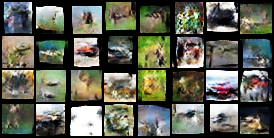

[Epoch 81/100] [D loss: -4.466900443786855] [G loss: 1229.1702153432705]
[Epoch 82/100] [D loss: -4.528039277362092] [G loss: 1228.9887820192614]
[Epoch 83/100] [D loss: -4.483824138751116] [G loss: 1229.0229787216772]
[Epoch 84/100] [D loss: -4.526750514574368] [G loss: 1228.9877416118027]
[Epoch 85/100] [D loss: -4.494970381259918] [G loss: 1228.8524772468431]
[Epoch 86/100] [D loss: -4.46977715266635] [G loss: 1228.8136342236453]
[Epoch 87/100] [D loss: -4.504242551448705] [G loss: 1228.6343098125799]
[Epoch 88/100] [D loss: -4.550950712560083] [G loss: 1228.5202578961696]
[Epoch 89/100] [D loss: -4.59326365933089] [G loss: 1228.4948196606258]
[Epoch 90/100] [D loss: -4.484761943902506] [G loss: 1228.459333727122]
Model weights checkpoint at epoch90 saved in weights/ directory.
Generated (fake) images at epoch90 saved in gan_images/ directory.


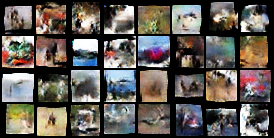

[Epoch 91/100] [D loss: -4.554754448973614] [G loss: 1228.223569904142]
[Epoch 92/100] [D loss: -4.522686373852098] [G loss: 1228.2535519026735]
[Epoch 93/100] [D loss: -4.512082320345027] [G loss: 1228.322043182295]
[Epoch 94/100] [D loss: -4.454498776084627] [G loss: 1228.3743603016105]
[Epoch 95/100] [D loss: -4.536518033508145] [G loss: 1228.3575005494724]
[Epoch 96/100] [D loss: -4.5048867183573105] [G loss: 1228.398229262408]
[Epoch 97/100] [D loss: -4.530140536520487] [G loss: 1228.3778116757912]
[Epoch 98/100] [D loss: -4.510312306911439] [G loss: 1228.3767981175572]
[Epoch 99/100] [D loss: -4.519654696859667] [G loss: 1228.3213180971268]
[Epoch 100/100] [D loss: -4.522513785020775] [G loss: 1228.2956660043858]
Model weights checkpoint at epoch100 saved in weights/ directory.
Generated (fake) images at epoch100 saved in gan_images/ directory.


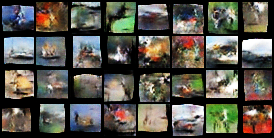

Final model weights saved in weights/ directory.


In [ ]:
# Create directory if it doesn't exist
os.makedirs("gan_images", exist_ok=True)
os.makedirs("weights", exist_ok=True)

# Lists to store discriminator and generator losses
d_losses = []
g_losses = []
epochs_list = []

# Lists to store losses for average line calculation
avg_d_losses = []
avg_g_losses = []

# Train generator and discriminator
for epoch in range(epochs):
    d_loss_total = 0.0
    g_loss_total = 0.0

    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(noise)
        real_preds = discriminator(real_images).view(-1)
        fake_preds = discriminator(fake_images.detach()).view(-1)
        d_loss = -(torch.mean(real_preds) - torch.mean(fake_preds)) + lambda_gp * compute_gradient_penalty(real_images, fake_images, discriminator)
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        # Train Generator
        if i % 5 == 0:
            optimizer_G.zero_grad()
            fake_preds = discriminator(fake_images).view(-1)
            g_loss = -torch.mean(fake_preds)
            g_loss.backward()
            optimizer_G.step()

        # Accumulate losses
        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()


    # Calculate average loss for the epoch
    d_loss_avg = d_loss_total / len(train_loader)
    g_loss_avg = g_loss_total / len(train_loader)

    # Append losses to lists
    d_losses.append(d_loss_avg)
    g_losses.append(g_loss_avg)
    epochs_list.append(epoch + 1)

    # Print progress
    # print(f"[Epoch {epoch + 1}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
    print(f"[Epoch {epoch + 1}/{epochs}] [D loss: {d_loss_avg}] [G loss: {g_loss_avg}]")

    # Adjust learning rate
    scheduler_G.step()
    scheduler_D.step()

    # Save model checkpoints and save & display generated images
    if (epoch + 1) % 10 == 0:
        fake_images = generate_images(generator, 32)
        torch.save(generator.state_dict(), f"weights/generator_{epoch + 1}.pth")
        torch.save(discriminator.state_dict(), f"weights/discriminator_{epoch + 1}.pth")
        print(f"Model weights checkpoint at epoch{epoch + 1} saved in weights/ directory.")
        save_image(fake_images, f"gan_images/{epoch + 1}.png", normalize=True)
        print(f"Generated (fake) images at epoch{epoch + 1} saved in gan_images/ directory.")
        display(Image(filename=f"gan_images/{epoch + 1}.png"))

# Save final model checkpoints
torch.save(generator.state_dict(), "weights/generator_final.pth")
torch.save(discriminator.state_dict(), "weights/discriminator_final.pth")
print(f"Final model weights saved in weights/ directory.")

In [ ]:
# Plot discriminator and generator losses
fig = go.Figure()

# Add scatter plots for losses
fig.add_trace(go.Scatter(x=epochs_list, y=d_losses, mode='lines+markers', name='Discriminator Loss'))
fig.add_trace(go.Scatter(x=epochs_list, y=g_losses, mode='lines+markers', name='Generator Loss'))

# Add average lines for every 5 epochs
for i in range(len(avg_d_losses)):
    epoch_start = i * 5 + 1
    epoch_end = min((i + 1) * 5, epochs)
    fig.add_shape(
        type="line",
        x0=epoch_start,
        y0=avg_d_losses[i],
        x1=epoch_end,
        y1=avg_d_losses[i],
        line=dict(
            color="black",
            width=1,
            dash="dash",
        ),
    )
    fig.add_shape(
        type="line",
        x0=epoch_start,
        y0=avg_g_losses[i],
        x1=epoch_end,
        y1=avg_g_losses[i],
        line=dict(
            color="black",
            width=1,
            dash="dash",
        ),
    )

fig.update_layout(
    title="Discriminator and Generator Losses",
    xaxis_title="Epoch",
    yaxis_title="Loss",
)

fig.show()